In [1]:
# Let’s start with the task of Time Series Forecasting with ARIMA.
#I will first collect Google stock price data using the Yahoo Finance API. 
import pandas as pd
import yfinance as yf
import datetime
from datetime import date, timedelta
today = date.today()

d1 = today.strftime("%Y-%m-%d")
end_date = d1
d2 = date.today() - timedelta(days=365)
d2 = d2.strftime("%Y-%m-%d")
start_date = d2

data = yf.download('GOOG', 
                      start=start_date, 
                      end=end_date, 
                      progress=False)
data["Date"] = data.index
data = data[["Date", "Open", "High", "Low", "Close", "Adj Close", "Volume"]]
data.reset_index(drop=True, inplace=True)
print(data.tail())

          Date        Open        High         Low       Close   Adj Close  \
245 2023-07-10  119.070000  119.070000  116.639999  116.870003  116.870003   
246 2023-07-11  116.760002  118.224998  115.830002  117.709999  117.709999   
247 2023-07-12  119.300003  120.959999  119.000000  119.620003  119.620003   
248 2023-07-13  121.540001  125.334999  121.059998  124.830002  124.830002   
249 2023-07-14  125.129997  127.089996  124.900002  125.699997  125.699997   

       Volume  
245  32960100  
246  18286600  
247  22059600  
248  31535900  
249  20482800  


In [2]:
#We only need the date and close prices columns for the rest of the task, 
# so let’s select both the columns and move further.
data = data[["Date", "Close"]]
print(data.head())

        Date       Close
0 2022-07-18  109.910004
1 2022-07-19  114.620003
2 2022-07-20  114.699997
3 2022-07-21  115.040001
4 2022-07-22  108.360001


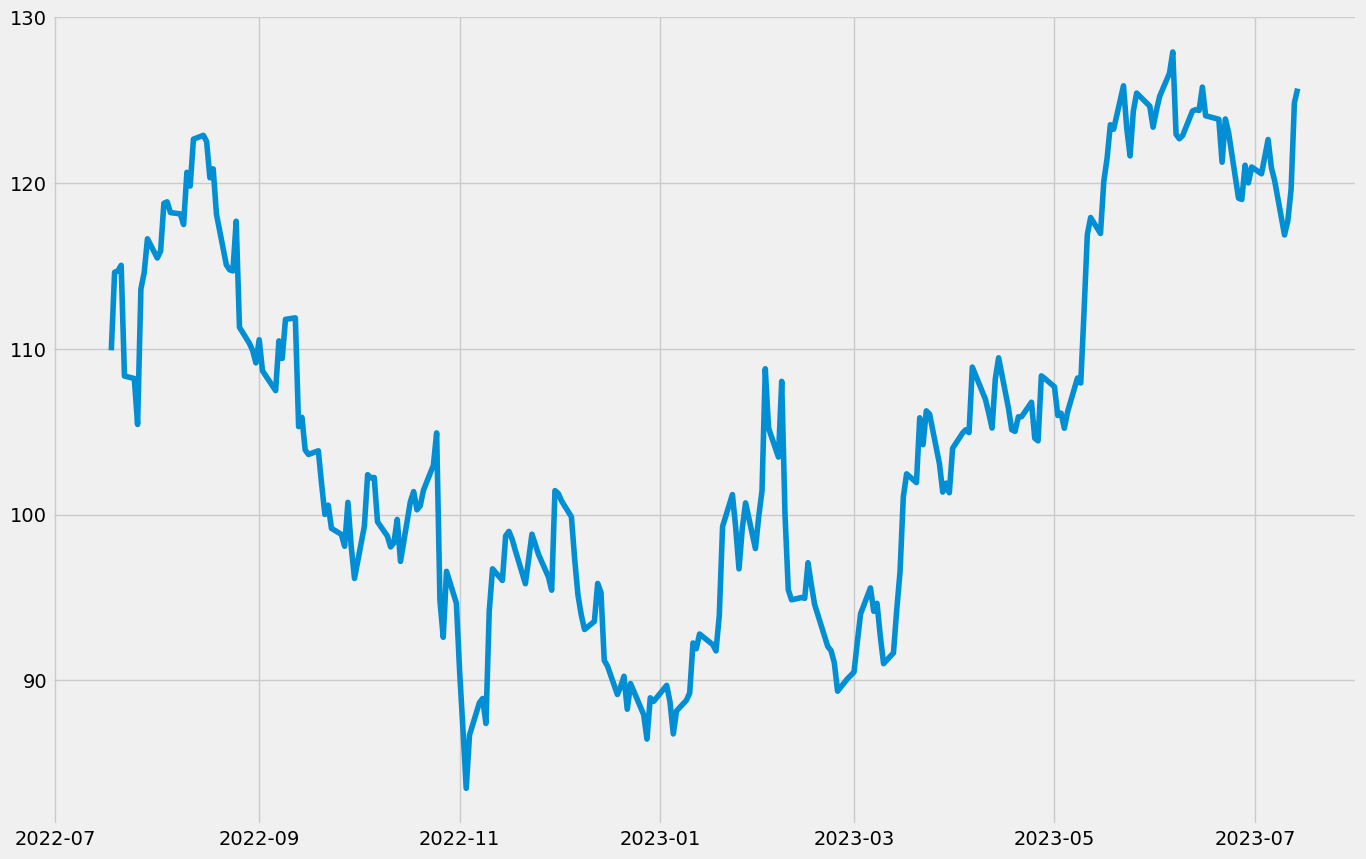

In [3]:
#Now let’s visualize the close prices of Google before moving forward.
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.figure(figsize=(15, 10))
plt.plot(data["Date"], data["Close"])

<Figure size 640x480 with 0 Axes>

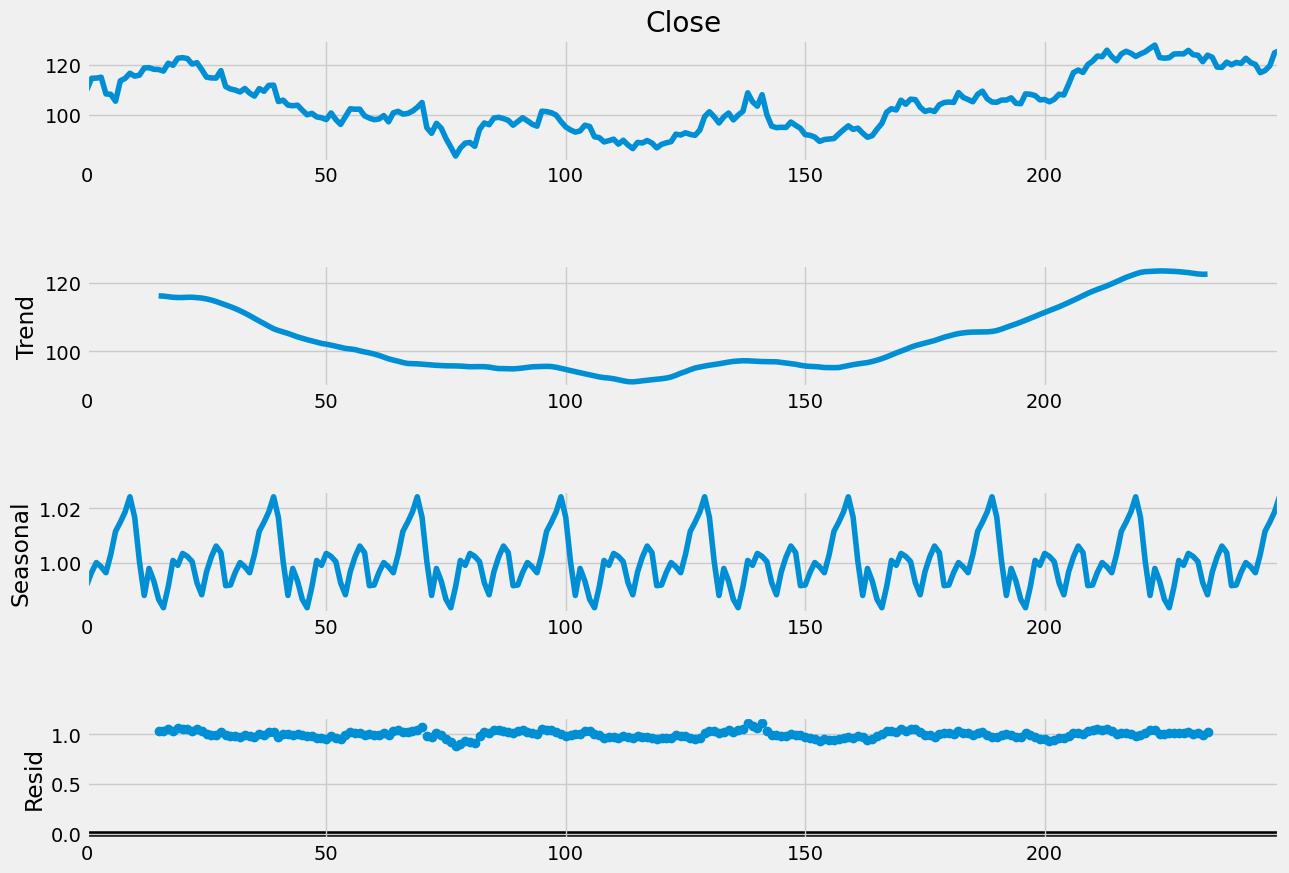

In [4]:
# Before using the ARIMA model, we have to figure out whether our data is stationary or seasonal. 
# The data visualization graph about the closing stock prices above shows that our dataset is not stationary.
#To check whether our dataset is stationary or seasonal properly, we can use the seasonal decomposition method that splits the time series data into trend, seasonal,
# and residuals for a better understanding of the time series data.
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(data["Close"], 
                            model='multiplicative', period = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(15, 10)

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

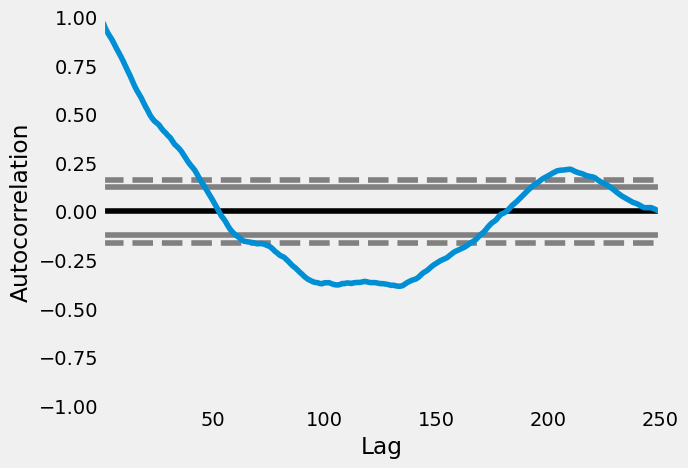

In [5]:
#To use ARIMA or SARIMA, we need to find the p, d, and q values.
#We can find the value of p by plotting the autocorrelation of the Close column and the value of q by plotting the partial autocorrelation plot. The value of d is either 0 or 1. If the data is stationary, we should use 0, and if the data is seasonal, we should use 1. As our data is seasonal, we should use 1 as the d value.

#Now here’s how to find the value of p:



pd.plotting.autocorrelation_plot(data["Close"])

/Users/jacobmclean/anaconda3/lib/python3.11/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


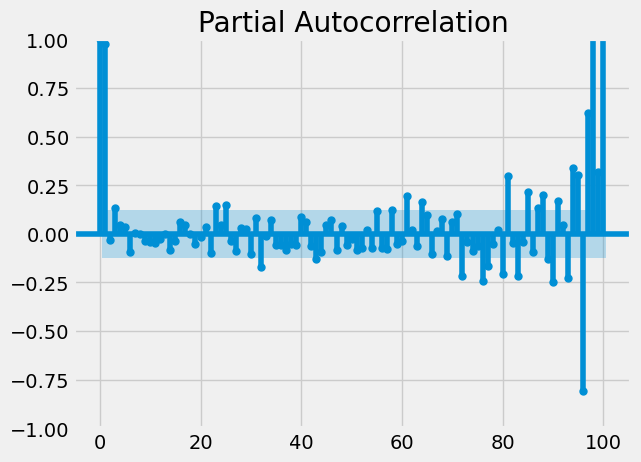

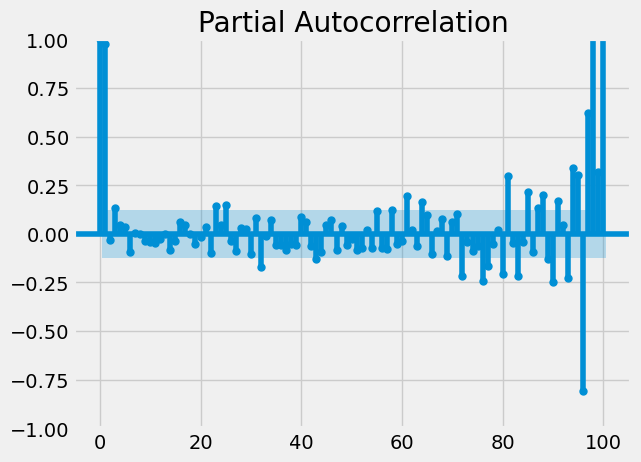

In [6]:
#In the above autocorrelation plot, the curve is moving down after the 5th line of the first boundary. That is how to decide the p-value.
#Hence the value of p is 5. Now let’s find the value of q.


from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(data["Close"], lags = 100)

In [8]:
# In the above partial autocorrelation plot, we can see that only two points are far away from all the points.
# That is how q value is decided.
# Thus, the value of q is 2. Now, we build an ARIMA model.


p, d, q = 5, 1, 2
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(data["Close"], order=(p,d,q))  
fitted = model.fit()  
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  250
Model:                 ARIMA(5, 1, 2)   Log Likelihood                -568.756
Date:                Sun, 16 Jul 2023   AIC                           1153.512
Time:                        20:25:33   BIC                           1181.652
Sample:                             0   HQIC                          1164.839
                                - 250                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0900      0.800      0.113      0.910      -1.477       1.657
ar.L2          0.7207      0.876      0.823      0.411      -0.996       2.437
ar.L3         -0.0436      0.114     -0.384      0.7

In [9]:
#Here’s how to predict the values using the ARIMA model.

predictions = fitted.predict()
print(predictions)

0        0.000000
1      109.910010
2      114.668682
3      114.272983
4      114.830024
          ...    
245    120.150734
246    117.039778
247    117.972336
248    119.762124
249    124.597425
Name: predicted_mean, Length: 250, dtype: float64


In [12]:
#The predicted values are wrong because the data is seasonal.
#Now, we build a SARIMA model.

import statsmodels.api as sm
import warnings
model=sm.tsa.statespace.SARIMAX(data['Close'],
                                order=(0, 0, 0),

                                seasonal_order=(0, 0, 0, 12))
model=model.fit()
print(model.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.07935D+00    |proj g|=  7.99361D-10

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   7.994D-10   6.079D+00
  F =   6.0793537698668567     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  250
Model:                        SARIMA

 This problem is unconstrained.


In [13]:
#Now let’s predict the future stock prices using the SARIMA model for the next 10 days.
predictions = model.predict(len(data), len(data)+10)
print(predictions)

250    0.0
251    0.0
252    0.0
253    0.0
254    0.0
255    0.0
256    0.0
257    0.0
258    0.0
259    0.0
260    0.0
Name: predicted_mean, dtype: float64


<Axes: >

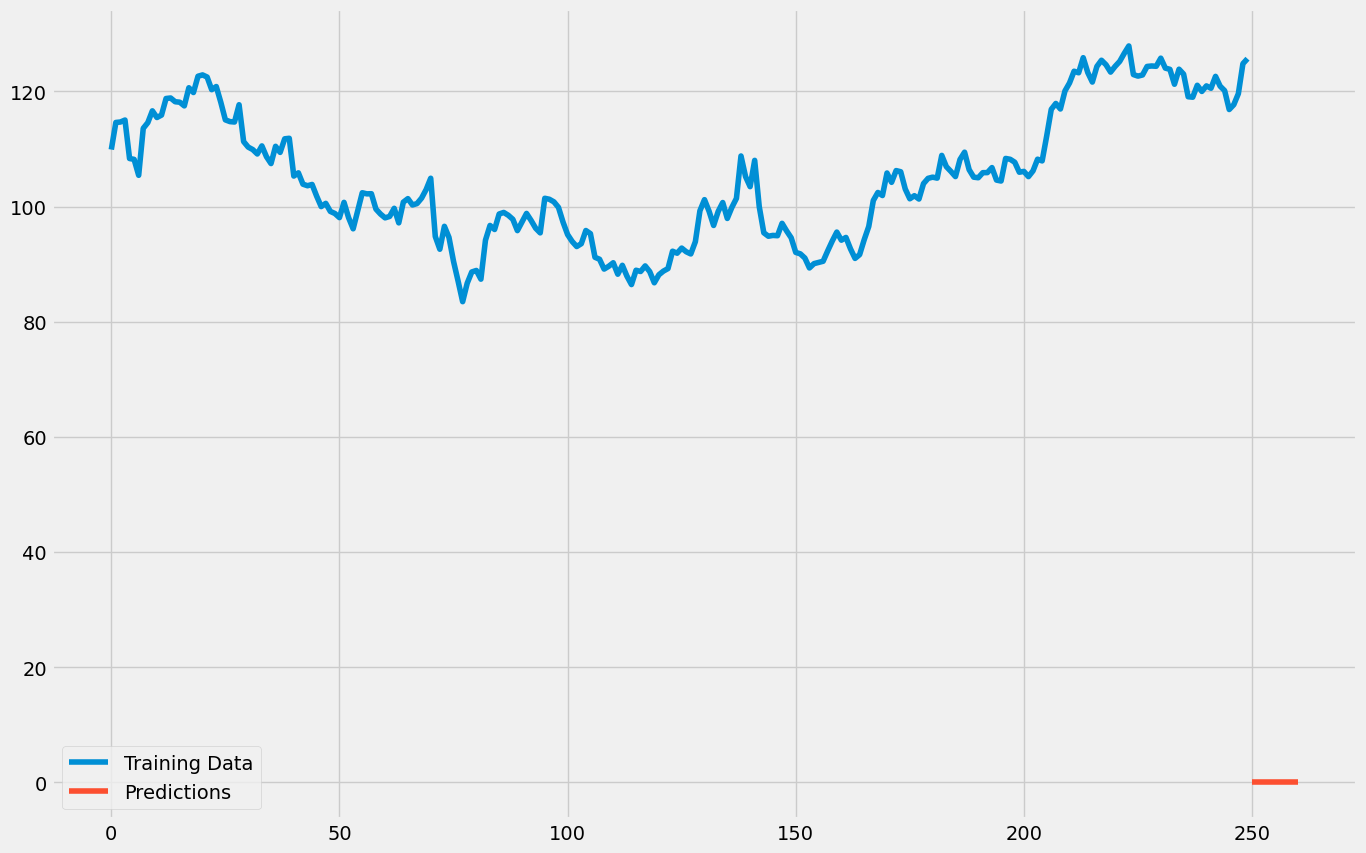

In [14]:
#Here’s how you can plot the predictions.
data["Close"].plot(legend=True, label="Training Data", figsize=(15, 10))
predictions.plot(legend=True, label="Predictions")